# Projekt zaliczeniowy - Bootcamp Data Science ING

### Autor: Kamila Rozpędek

### Temat 2 - Przewidywanie udzielenia pożyczki. 

Celem projektu jest zastosowanie modeli klasyfikacji (binarnej) do
przewidzenia czy pożyczka zostanie udzielona danemu klientowi z danymi parametrami wniosku.

In [1]:
#Import bibliotek:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

In [2]:
#Załadowanie danych
location = 'https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv'
data=pd.read_csv(location, parse_dates=['DOB', 'Lead_Creation_Date'], encoding='cp1250')

In [3]:
#Inna możliwość załadowania danych - z dysku
#location = r'Train.csv'
#data = pd.read_csv(location, parse_dates=['DOB', 'Lead_Creation_Date'], encoding='cp1250')

In [4]:
data.head(5)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,1978-05-23,2015-05-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,1985-10-07,2015-05-04,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,1981-10-10,2015-05-19,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,1987-11-30,2015-05-09,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,1984-02-17,2015-05-20,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [5]:
#Usunięcie kolumn nie biorących udziału w modelowaniu
data=data.drop(columns=["ID", "LoggedIn"])

In [6]:
#Zmienna celu - spawdzenie wartości
data["Disbursed"].value_counts()

0    85747
1     1273
Name: Disbursed, dtype: int64

In [7]:
#Podstawowe informacje o danych
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Gender                 87020 non-null  object        
 1   City                   86017 non-null  object        
 2   Monthly_Income         87020 non-null  int64         
 3   DOB                    87020 non-null  datetime64[ns]
 4   Lead_Creation_Date     87020 non-null  datetime64[ns]
 5   Loan_Amount_Applied    86949 non-null  float64       
 6   Loan_Tenure_Applied    86949 non-null  float64       
 7   Existing_EMI           86949 non-null  float64       
 8   Employer_Name          86949 non-null  object        
 9   Salary_Account         75256 non-null  object        
 10  Mobile_Verified        87020 non-null  object        
 11  Var5                   87020 non-null  int64         
 12  Var1                   87020 non-null  object        
 13  L

W zbiorze występują dwie daty. Zmienna DOB (data urodzenia) zostanie przerobiona na zmienną "age" wnioskującego przy wykorzystaniu zmiennej "Lead_Creation_Date". Następnie obie zmienne zostaną usunięte.

Zbiór posiada następujące zmienne jakościowe (opisowe lub pokateryzowane): Gender, City, Employer_Name, Salary_Account, Mobile_Verified, Var1 (Categorical variable with multiple levels), Filled_Form, Device_Type, Var2 (Categorical variable with multiple levels), Source, Var4 (Categorical Variable with multiple Levels), Var5 (Continuous classified variable). Zostaną one przebadane, w razie potrzeby przekształcone, a następnie przekodowane na zmienne dummy.

Pozostałe zmienne to zmienne ciągłe - zostaną dokładnie przebadane i odpowiednio przekształcone.

#### Daty - przygotowanie

In [8]:
print(data["Lead_Creation_Date"].max())
print(data["Lead_Creation_Date"].min())
print("------------------")
print(data["DOB"].min())
print(data["DOB"].max())

2015-07-31 00:00:00
2015-05-01 00:00:00
------------------
1971-01-01 00:00:00
2070-12-31 00:00:00


In [9]:
#Stworzenie zmiennej wiek:
data["creation"]=data["Lead_Creation_Date"].dt.year
data["birth"]=data["DOB"].dt.year

data["age"] = data["creation"] - data["birth"]      

-55
44


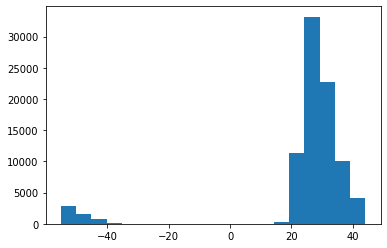

In [10]:
#Sprawdzenie wartości zmiennej wiek
print(data["age"].min())
print(data["age"].max())

#Histogram dla zmiennej wiek
plt.hist(data["age"], bins=20)
plt.show()

Zmienna DOB zawiera niepoprawne dane (DOB późniejsza niż Lead Creation date). Wygląda na to, że przez pomyłke lata przed 1971 rokiem zostały wprowadzone jako analogiczne data po 2000 roku - np. zamiast 1961 mamy 2061). Po stworzeniu zmiennej "age" wszystkie przypadki, gdzie wnioskujący będzie mieć ujemny wiek zostaną skorygowane (dodane do nich zostanie 100).

In [11]:
#Nadpisanie wieku dla obserwacji, gdze wartość zmiennej jest niepoprawna
query_age= (data["age"] < 0)
data.loc[query_age, "age"] = data["age"]+100

0
86


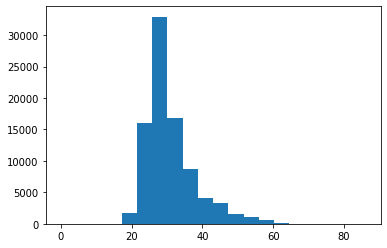

In [12]:
#Sprawdzenie wyniku nadpisania na wykresie
print(data["age"].min())
print(data["age"].max())

plt.hist(data["age"], bins=20)
plt.show()

In [13]:
#data["age"].value_counts().head(60)

Jest 17 przypadków wartości 0 - będzie ona potraktowana jako brak i wypełniona medianą

In [14]:
#Wyliczenie mediany wieku
data2=data[data["age"] > 0]
median_age=data2["age"].median()

#Ndpisanie 0
query_age2= (data["age"] == 0)
data.loc[query_age2, "age"] = median_age

print(data["age"].min())
print(data["age"].max())

18.0
86.0


In [15]:
#Usunięcie niepotrzebnych kolumn z danych (daty)
data=data.drop(columns=["Lead_Creation_Date", "DOB", "creation", "birth"])

In [16]:
data.head(5)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,age
0,Female,Delhi,20000,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,37.0
1,Male,Mumbai,35000,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,30.0
2,Male,Panchkula,22500,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,34.0
3,Male,Saharsa,35000,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,28.0
4,Male,Bengaluru,100000,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,0,31.0


#### Zmienne jakościowe - przygotowanie

In [17]:
#Zmienna Var5
#print(data["Var5"].value_counts())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DDD512C408>],
      dtype=object)

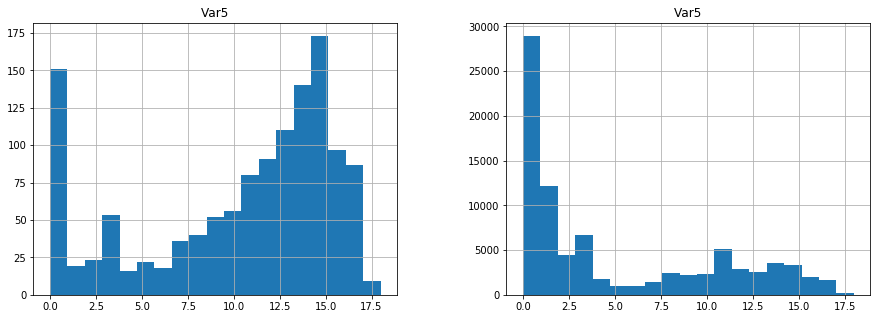

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
data[data["Disbursed"] == 1].hist(column = "Var5", bins= 19,  ax = axes[0])
data[data["Disbursed"]  == 0].hist(column = "Var5", bins= 19,  ax = axes[1])

Powyższe wykresy wskazują zależność między poziomem zmiennej, a zmienną Disbursed. Najwięcej przypadków, gdzie Disbursed =1 ma miejsce dla wysokich wartości Var5 (z przedziału 13-15). Duża część zbioru ma niskie wartości - przy niskich wartościach obserwujemy też małe liczności Disbursed=1. Kategoria 0 powinna być kategorią osobną. Zmienna zostanie zatem pokategoryzowana.

In [19]:
dv1={0:0}
dv2={i: 123 for i in [1,2,3]}
dv3={i: 45678 for i in [4,5,6,7,8]}
dv4={i: 9101112 for i in [9,10,11,12]}
dv5={i: 131415 for i in [13,14,15]}
dv6={i: 161718 for i in [16,17,18]}

dict_var5=dict()

for dictionary in [dv1, dv2, dv3, dv4, dv5, dv6]:
    dict_var5.update(dictionary)

In [20]:
#dict_var5

In [21]:
#Przemapowanie zmiennej Var5
data["Var5"]=data["Var5"].map(dict_var5)

In [22]:
data["Var5"].value_counts()

0          29087
123        23480
9101112    12901
131415      9793
45678       7777
161718      3982
Name: Var5, dtype: int64

In [23]:
#Zmienna Salary_Account
#print(data["Salary_Account"].value_counts())

Zmienna Salary_Account zostanie pogrupowana. Powstanie 5 grup stworzonych w oparciu o % klientów z udzielonym kredytem wśród posiadaczy konta w danym banku. Dodatkowy, 6 poziom zmiennej zostanie przypisany dla obserwacji z brakiem w tej zmiennej.

In [24]:
#Podzielenie zmiennej na grupy w zależności od % udziału
no=data["Disbursed"]==0
yes=data["Disbursed"]==1

rejected= pd.DataFrame(data[no])
disbursed= pd.DataFrame(data[yes])

share = pd.DataFrame({
                    "total": data["Gender"].groupby(data["Salary_Account"]).count(),
                    "rejected": rejected["Gender"].groupby(rejected["Salary_Account"]).count(),
                    "disbursed": disbursed["Gender"].groupby(disbursed["Salary_Account"]).count(),
                    "share_disbursed": disbursed["Gender"].groupby(disbursed["Salary_Account"]).count()*100/data["Gender"].groupby(data["Salary_Account"]).count()
                                        })
share1=share.fillna({
    'disbursed': 0,
    'share_disbursed': 0
})

In [25]:
#share1

Dane zostaną podzielone na podkategorie w zależności od odsetka disbursed oraz liczności danej grupy. Wyrożnione zostaną następujące grupy:
Duże banki - ponad 500 obserwacji (udział): bardzo duży, duży, średni, mały, bardzo mały;
Małe banki - do 500 obserwacji (udział): duży, mały;

In [26]:
#big banks
big1=share1[(share1["total"]>= 500) & (share1["share_disbursed"]>=2.5)]
big2=share1[(share1["total"]>= 500) & (share1["share_disbursed"]<2.5) & (share1["share_disbursed"]>=2)]
big3=share1[(share1["total"]>= 500) & (share1["share_disbursed"]<2) & (share1["share_disbursed"]>=1.5)]
big4=share1[(share1["total"]>= 500) & (share1["share_disbursed"]<1.5) & (share1["share_disbursed"]>=1)]
big5=share1[(share1["total"]>= 500) & (share1["share_disbursed"]<1)]
#small banks
small1=share1[(share1["total"]< 500) & (share1["share_disbursed"]>=1)]
small2=share1[(share1["total"]< 500) & (share1["share_disbursed"]<1)]

#list(big1.index)

In [27]:
#Stworzenie słowników dla podmiany wartości zmiennej
d1={i: "big_very_high_share" for i in list(big1.index)}
d2={i: "big_high_share" for i in list(big2.index)}
d3={i: "big_medium_share" for i in list(big3.index)}
d4={i: "big_low_share" for i in list(big4.index)}
d5={i: "big_very_low_share" for i in list(big5.index)}
d6={i: "small_big_share" for i in list(small1.index)}
d7={i: "small_low_share" for i in list(small2.index)}
#d5

In [28]:
#Złączenie słowników w 1
dict_acc=dict()

for dictionary in [d1, d2, d3, d4, d5, d6, d7]:
    dict_acc.update(dictionary)

In [29]:
#dict_acc

In [30]:
#Przemapowanie Salary_Account
data["Salary_Account"]=data["Salary_Account"].map(dict_acc)

In [31]:
#Ile braków ma zmienna?
data["Salary_Account"].isnull().sum()

11764

Informacja o braku danych w przypadku Salary Account może być cenna dlatego zostanie jej przypisany osobny poziom

In [32]:
data["Salary_Account"]=data["Salary_Account"].replace(np.nan, "missing")

In [33]:
data["Salary_Account"].value_counts()

big_high_share         31331
big_very_low_share     18470
big_medium_share       12054
missing                11764
big_low_share           4054
small_low_share         3390
big_very_high_share     3371
small_big_share         2586
Name: Salary_Account, dtype: int64

In [34]:
#Employer_Name
#print(data["Employer_Name"].value_counts())

Zmienna Employer Name zostanie podzielona na mniejsze kategorie na podstawie liczności obserwacji. 

In [35]:
#Ile braków ma zmienna?
data["Employer_Name"].isnull().sum()

71

In [36]:
#Stworzenie kategorii na braki - zmienna ma także błędne wartości wskazujące na braki jak np. puste pola lub kropki
data["Employer_Name"]=data["Employer_Name"].replace(np.nan, "missing").str.strip().replace("", "missing").replace(".", "missing")

In [37]:
#Podmiana nazwy kategorii 0
data["Employer_Name"]=data["Employer_Name"].replace("0", "category_0")

In [38]:
#Stworzenie tabelki pomocniczej do wyznaczenia kategorii
no=data["Disbursed"]==0
yes=data["Disbursed"]==1

rejected= pd.DataFrame(data[no])
disbursed= pd.DataFrame(data[yes])

employers = pd.DataFrame({
                    "total": data["Gender"].groupby(data["Employer_Name"]).count(),
                    "rejected": rejected["Gender"].groupby(rejected["Employer_Name"]).count(),
                    "disbursed": disbursed["Gender"].groupby(disbursed["Employer_Name"]).count(),
                    "share_disbursed": disbursed["Gender"].groupby(disbursed["Employer_Name"]).count()*100/data["Gender"].groupby(data["Employer_Name"]).count()
                                        })
employers=employers.fillna({
    'disbursed': 0,
    'share_disbursed': 0
})

In [39]:
#employers[employers["total"]>60]

Kategoria 0 zostanie osobną kategorią. 
Zakłady pracy liczące dokładnie 1 pracownika są to najczęściej wartości błędne, jest to również NAJWIĘKSZA część zbioru , więc stworzą one osobną kategorię. Do tej kategorii zostaną zakwalifikowane braki (jako do wartości najczęstszej i podobnej jakościowo).
Podobnie z zakładami liczącymi dokładnie 2 pracowników - ze względu na liczność oraz występwnie tam niepoprawnych wartości stworzą osobną kategorię. Pozostałe zakłady pracy zostaną pogrupowane wzgledem wielkości pracodawcy i odsetka disbursed.

In [40]:
#Stworzenie kategorii
#other
cat_0 = employers.query('index == "category_0"')
cat_1 = employers.query('(total == 1) or (index == "missing") and (index != "category_0")')
cat_2 = employers.query('(total == 2) and (index != "missing") and (index != "category_0")')

#big employers
cat_3 = employers.query('(total>= 50) and (share_disbursed>=3) and (index != "missing") and (index != "category_0")')
cat_4 = employers.query('(total>= 50) and (share_disbursed <3) and (share_disbursed >=1.5) and (index != "missing") and (index != "category_0")')
cat_5 = employers.query('(total>= 50) and (share_disbursed<1.5) and (index != "missing") and (index != "category_0")')

#med employers
cat_6 = employers.query('(total>= 15) and (total <50) and (share_disbursed>=1.5) and (index != "missing") and (index != "category_0")')
cat_7 = employers.query('(total>= 15) and (total <50) and(share_disbursed<1.5) and (index != "missing") and (index != "category_0")')

#small employers
cat_8 = employers.query('(total< 15) and (total>2) and (share_disbursed>=1.5) and (index != "missing") and (index != "category_0")')
cat_9 = employers.query('(total< 15) and (total>2) and (share_disbursed<1.5) and (index != "missing") and (index != "category_0")')

#list(cat_7.index)

In [41]:
#Stworzenie słowników na podstawie kategorii
c1={i: "cat_0" for i in list(cat_0.index)}
c2={i: "cat_1" for i in list(cat_1.index)}
c3={i: "cat_2" for i in list(cat_2.index)}

c4={i: "big_high_share" for i in list(cat_3.index)}
c5={i: "big_med_share" for i in list(cat_4.index)}
c6={i: "big_low_share" for i in list(cat_5.index)}

c7={i: "med_high_share" for i in list(cat_6.index)}
c8={i: "med_low_share" for i in list(cat_7.index)}

c9={i: "small_high_share" for i in list(cat_8.index)}
c10={i: "small_small_share" for i in list(cat_9.index)}
#c10

In [43]:
#Złączenie słowników w 1
dict_empl=dict()

for dictcat in [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10]:
    dict_empl.update(dictcat)

In [44]:
#dict_empl

In [45]:
#Przemapowanie Employer_Name
data["Employer_Name"]=data["Employer_Name"].map(dict_empl)

In [46]:
data["Employer_Name"].value_counts()

cat_1                32828
small_small_share    19224
cat_2                10726
med_low_share         5746
cat_0                 4914
med_high_share        3546
big_low_share         3322
big_high_share        2418
small_high_share      2247
big_med_share         2049
Name: Employer_Name, dtype: int64

In [51]:
#City
print(data["City"].value_counts().head(10))

Delhi        12527
Bengaluru    10824
Mumbai       10795
Hyderabad     7272
Chennai       6916
Pune          5207
Kolkata       2888
Ahmedabad     1788
Jaipur        1331
Gurgaon       1212
Name: City, dtype: int64


Zmienna City zostanie podzielona na podstawie liczności obserwacji (największe miasta wg liczności zbioru jest faktycznie największymi miastami w Indiach). Największe miasta będą osobnymi kategoriami.

In [47]:
#Sprawdzenie braków
data["City"].isnull().sum()
#Braki są dość liczną kategorią - zostaną potraktowane jako osobny poziom zmiennej.

1003

In [48]:
#Stworzenie kategorii na braki
data["City"]=data["City"].replace(np.nan, "missing")

In [49]:
cities = pd.DataFrame({
                    "total": data["Gender"].groupby(data["City"]).count(),
                    "rejected": rejected["Gender"].groupby(rejected["City"]).count(),
                    "disbursed": disbursed["Gender"].groupby(disbursed["City"]).count()
                                        })

In [52]:
#Stworzenie kategorii
city_Delhi = cities.query('index == "Delhi"')
city_Bengaluru = cities.query('index == "Bengaluru"')
city_Mumbai = cities.query('index == "Mumbai"')
city_Hyderabad = cities.query('index == "Hyderabad"')
city_Chennai = cities.query('index == "Chennai"')
city_Pune = cities.query('index == "Pune"')
city_Kolkata = cities.query('index == "Kolkata"')

city_missing = cities.query('index == "missing"')

city_large = cities.query('(total < 2000) and (total >= 1000) and (index != "missing")')
city_big = cities.query('(total < 1000) and (total >= 500) and (index != "missing")')
city_medium = cities.query('(total < 500) and (total >= 90) and (index != "missing")')
city_small = cities.query('(total < 90) and (index != "missing")')

#city_large.sum()

total        5478.0
rejected     5393.0
disbursed      85.0
dtype: float64

In [53]:
#Stworzenie słowników na podstawie kategorii
city1={i: "Delhi" for i in list(city_Delhi.index)}
city2={i: "Bengaluru" for i in list(city_Bengaluru.index)}
city3={i: "Mumbai" for i in list(city_Mumbai.index)}
city4={i: "Hyderabad" for i in list(city_Hyderabad.index)}
city5={i: "Chennai" for i in list(city_Chennai.index)}
city6={i: "Pune" for i in list(city_Pune.index)}
city7={i: "Kolkata" for i in list(city_Kolkata.index)}
city8={i: "missing" for i in list(city_missing.index)}
city9={i: "large" for i in list(city_large.index)}
city10={i: "big" for i in list(city_big.index)}
city11={i: "medium" for i in list(city_medium.index)}
city12={i: "small" for i in list(city_small.index)}

In [54]:
#Złączenie słowników w 1
dict_city=dict()

for dictcit in [city1, city2, city3, city4, city5, city6, city7, city8, city9, city10, city11, city12]:
    dict_city.update(dictcit)
    
#dict_city

In [55]:
#Przemapowanie
data["City"]=data["City"].map(dict_city)
data["City"].value_counts()

Delhi        12527
Bengaluru    10824
Mumbai       10795
small         8917
medium        8247
Hyderabad     7272
big           6946
Chennai       6916
large         5478
Pune          5207
Kolkata       2888
missing       1003
Name: City, dtype: int64

In [57]:
#data["City"].groupby(data["Disbursed"]).value_counts()

In [59]:
#Source
#print(data["Source"].value_counts())

Zmienna Source ma wiele poziomów o małych licznościach - poziomy posiadające mniej niż 1000 przypadków zostaną złączone w 1 kategorię "other".

In [60]:
src = pd.DataFrame({
                    "total": data["Gender"].groupby(data["Source"]).count()
                                        })
src_to_group=list(src.index[src["total"]<1000])
#src_to_group

In [61]:
#Podmiana nazwy source w małolicznych grupach na "OTHER"
data["Source"]=data["Source"].replace(src_to_group, "OTHER")

In [63]:
#data["Source"].groupby(data["Disbursed"]).value_counts()

In [82]:
#Var4
#print(data["Var4"].value_counts())

In [81]:
#data["Var4"].groupby(data["Disbursed"]).value_counts()

Poziomy zmiennej 4 o wartościach 0, 6, 7 zostaną zgrupowane w 1 ze względu na niższą liczbę przypadków oraz bardzo małą liczebność Disbursed=1.

In [66]:
var_gr=[0,7]
data["Var4"]=data["Var4"].replace(var_gr, 6)
print(data["Var4"].value_counts())

3    25260
1    23906
5    20266
4     6577
2     5931
6     5080
Name: Var4, dtype: int64


In [80]:
#Var2
#print(data["Var2"].value_counts())

In [75]:
#data["Var2"].groupby(data["Disbursed"]).value_counts()

Niektóre zmienne są małoliczne i wymagają pogrupowania. W jedną kategorię złączone zostaną poziomy D i A, a w drugą poziomy E i F.

In [69]:
data["Var2"]=data["Var2"].replace("A", "D").replace("F", "E")
print(data["Var2"].value_counts())

B    37280
G    33032
C    14210
E     1859
D      639
Name: Var2, dtype: int64


In [74]:
#Var1
#print(data["Var1"].value_counts()) #- kilka poziomów

In [72]:
#data["Var1"].groupby(data["Disbursed"]).value_counts()

Var1 zostanie pogrupowana tak, aby kategorie liczyły conajmniej 1000 obserwacji, do grupowania wykorzystana zostanie zmienna Disbursed.

In [73]:
gr1=["HCXF", "HAXM", "HAVC"]
gr2=["HBXH", "HAYT", "HCXD", "HCYS", "HVYS", "HAZD", "HCXG", "HAXF"]
data["Var1"]=data["Var1"].replace(gr1,"HCXF_HAXM_HAVC").replace(gr2,"OTHER" )
print(data["Var1"].value_counts())

HBXX              59294
HBXC               9010
HBXB               4479
HAXA               2909
OTHER              2320
HBXA               2123
HAXB               2011
HBXD               1964
HAXC               1536
HCXF_HAXM_HAVC     1374
Name: Var1, dtype: int64


In [78]:
print(data["Device_Type"].value_counts()) 
print("-----------------------------")
print(data["Filled_Form"].value_counts())
print("-----------------------------")
print(data["Mobile_Verified"].value_counts())
print("-----------------------------")
print(data["Gender"].value_counts())

Web-browser    64316
Mobile         22704
Name: Device_Type, dtype: int64
-----------------------------
N    67530
Y    19490
Name: Filled_Form, dtype: int64
-----------------------------
Y    56481
N    30539
Name: Mobile_Verified, dtype: int64
-----------------------------
Male      49848
Female    37172
Name: Gender, dtype: int64


Pozostałe zmienne jakościowe nie wymagają przekształceń i można je uwzględnić w modelu po przekodowaniu na dummy.

In [79]:
data.columns

Index(['Gender', 'City', 'Monthly_Income', 'Loan_Amount_Applied',
       'Loan_Tenure_Applied', 'Existing_EMI', 'Employer_Name',
       'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'Disbursed', 'age'],
      dtype='object')

In [83]:
#Przygotowanie wektora zmiennych do przekodowania na DUMMY oraz wektora zmiennych numerycznych
dummy=['Gender', 'City', 'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var4', 'Var5']
numeric=['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee', 'EMI_Loan_Submitted', 'age']

#### Zmienne ilościowe - przygotowanie

Zmienne ilościowe wymagają osobnej analizy w celu zidentyfikowania braków i wypełnienia ich odpowiednimi wartościami. Zmienna age jest już przygotowana.

Monthly_Income


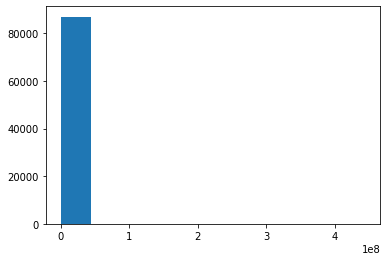

Loan_Amount_Applied


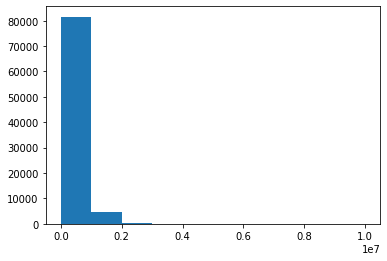

Loan_Tenure_Applied


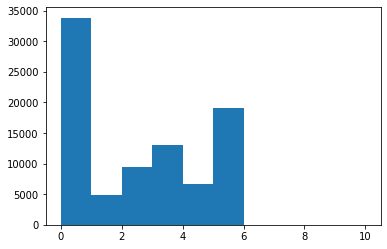

Existing_EMI


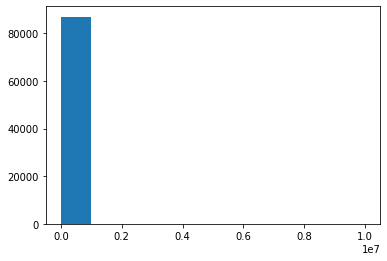

Loan_Amount_Submitted


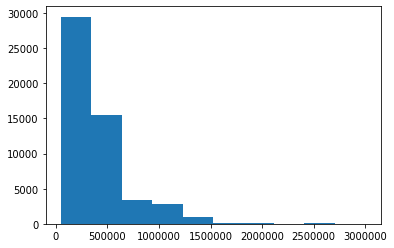

Loan_Tenure_Submitted


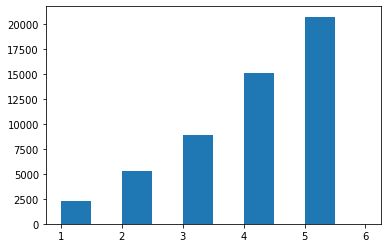

Interest_Rate


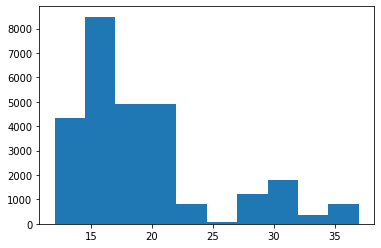

Processing_Fee


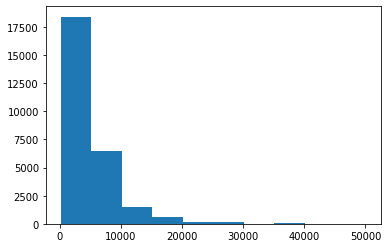

EMI_Loan_Submitted


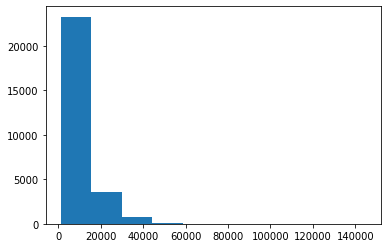

age


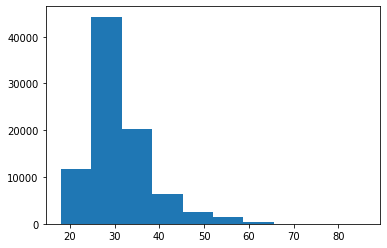

In [85]:
#Histogramy dla zmiennych numerycznych
for var in numeric:
    plt.hist(data[var])
    plt.title(print(var), fontsize=12)
    plt.show()

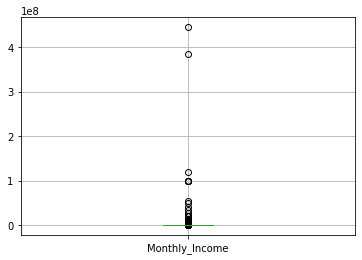

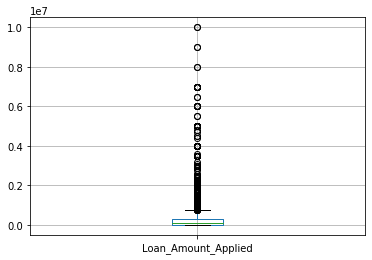

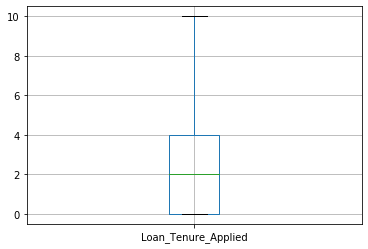

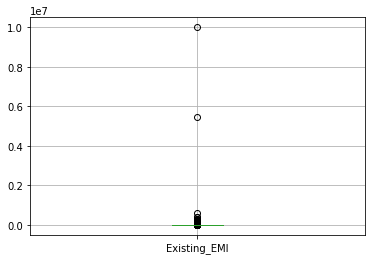

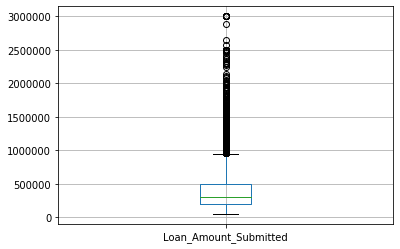

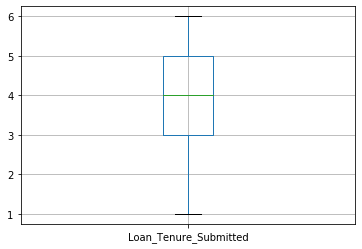

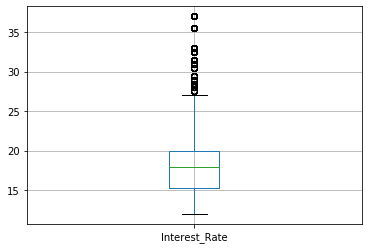

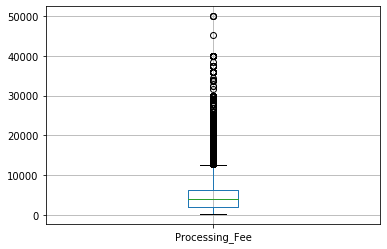

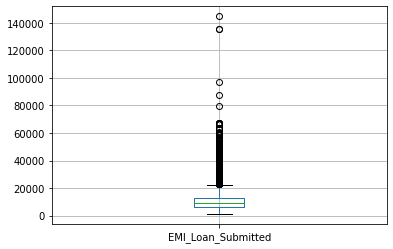

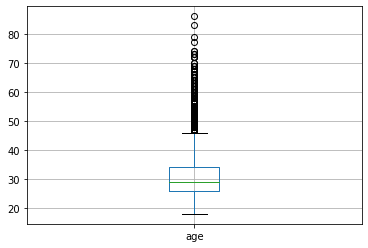

In [86]:
#Boxplots
for var in numeric:
    data.boxplot(column=[var])
    plt.show()

In [88]:
#Podstawowe statystyki dla zmiennych numerycznych
for var in numeric:
    print(f'Zmienna: {var}')
    print(f'Minimum: {data[var].min()}')
    print(f'Maksimum: {data[var].max()}')
    print(f'Średnia: {data[var].mean()}')
    print(f'Mediana: {data[var].median()}')
    print(f'1 percentyl: {np.percentile(data[var], 1)}')
    print(f'99 percentyl: {np.percentile(data[var], 99)}')
    print(f'Liczba nulli: {data[var].isnull().sum()}')
    print('-----------------------------------')

Zmienna: Monthly_Income
Minimum: 0
Maksimum: 444554443
Średnia: 58849.97435072397
Mediana: 25000.0
1 percentyl: 2583.0
99 percentyl: 250000.0
Liczba nulli: 0
-----------------------------------
Zmienna: Loan_Amount_Applied
Minimum: 0.0
Maksimum: 10000000.0
Średnia: 230250.69992754373
Mediana: 100000.0
1 percentyl: nan
99 percentyl: nan
Liczba nulli: 71
-----------------------------------
Zmienna: Loan_Tenure_Applied
Minimum: 0.0
Maksimum: 10.0
Średnia: 2.131398866001909
Mediana: 2.0
1 percentyl: nan
99 percentyl: nan
Liczba nulli: 71
-----------------------------------
Zmienna: Existing_EMI
Minimum: 0.0
Maksimum: 10000000.0
Średnia: 3696.227823896767
Mediana: 0.0
1 percentyl: nan
99 percentyl: nan
Liczba nulli: 71
-----------------------------------
Zmienna: Loan_Amount_Submitted
Minimum: 50000.0
Maksimum: 3000000.0
Średnia: 395010.59018833365
Mediana: 300000.0
1 percentyl: nan
99 percentyl: nan
Liczba nulli: 34613
-----------------------------------
Zmienna: Loan_Tenure_Submitted
Mini

Zmienna Monthly_Income nie ma braków, ale posiada dużo wartości odstających (99 percentyl to 250tys rupii). Na wartości tej zmiennej zostanie nałożony cap w wysokości 99 percentyla wartości tej zmiennej. 

In [89]:
cap_income=np.percentile(data["Monthly_Income"], 99)

In [90]:
#Spr ile przypadków będzie miec "przycięty" dochód
query_income = data["Monthly_Income"] > cap_income
cust_to_cap=data.loc[query_income]
cust_to_cap["Gender"].count()    

819

In [91]:
#Nadpisanie zmiennej Monthly_Income
data.loc[query_income, "Monthly_Income"] = cap_income

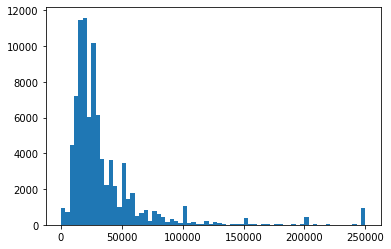

In [92]:
plt.hist(data["Monthly_Income"], bins=70)
plt.show()

Zmienna ma rozkład skośny - wartość zmiennej zostanie poprawiona (pierwiastek)

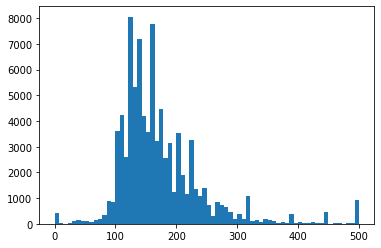

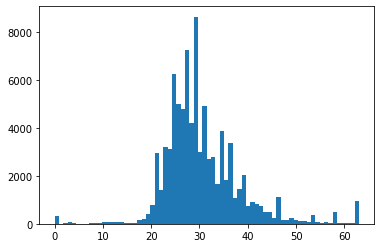

In [93]:
plt.hist(pow(data["Monthly_Income"],1/2), bins=70)
plt.show()

plt.hist(pow(data["Monthly_Income"],1/3), bins=70)
plt.show()

In [94]:
#Nadpisanie wartości pierwiastkiem sześciennym
data["Monthly_Income"] = pow(data["Monthly_Income"], 1/3)

Zmienna Loan_Amount_Applied posiada braki (71 przypadków), które trzeba zaimputować - wykorzystana zostanie mediana (bardziej odporna na outliery niz średnia). Zmienna posiada sporo outlierów oraz wartości równych 0. Wartości równe 0 zostaną niezmienione - potraktowane jako specyficzny rodzaj braku danych. Na wartości powyżej 99 percentyle nałożony będzie cap.

In [95]:
#Sprawdzenie wartości 0
query_am0 = data["Loan_Amount_Applied"] == 0
zeros=data.loc[query_am0]
zeros["Gender"].count() 

28853

In [96]:
#Wyliczenie poprawnej mediany (na wartościach bez bez nulli i zer)
data1=data.query('Loan_Amount_Applied > 0')
#data1["Loan_Amount_Applied"].isnull().sum()

med_loan_appl=data1["Loan_Amount_Applied"].median()
med_loan_appl

200000.0

In [97]:
#Wypełnienie braków
data["Loan_Amount_Applied"]=data["Loan_Amount_Applied"].replace(np.nan, med_loan_appl)

In [98]:
print(f'99 percentyl: {np.percentile(data1["Loan_Amount_Applied"], 99)}')

99 percentyl: 1800000.0


Maksymalną wartością zmiennej Loan Amount Submitted jest 3 mln. Mimo, że 99 percentyl zmiennej Loan Amount Applied jest niższy niż ta wartość, maksymalna wartość Loan Amount Applied zostanie ustawiona także jako 3mln.

In [99]:
#Spr ile przypadków wykracza poza 99 percentyl oraz poza 3 mln
cap_la=np.percentile(data["Loan_Amount_Applied"], 99)
cap_la2= 3000000
query_la = data["Loan_Amount_Applied"] > cap_la2 #cap_la
cust_to_cap1=data.loc[query_la]
cust_to_cap1["Gender"].count()   

102

In [100]:
#Nałożenie capa na wartości zmiennej
data.loc[query_la, "Loan_Amount_Applied"] = cap_la2

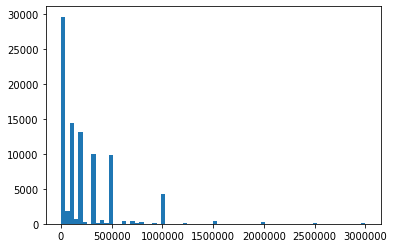

In [101]:
plt.hist(data["Loan_Amount_Applied"], bins=70)
plt.show()

Rozkład zmiennej jest skośny - jej wartości zostaną zamienione na pierwiastki wartości.

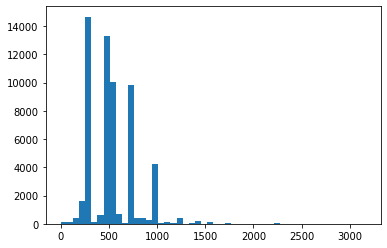

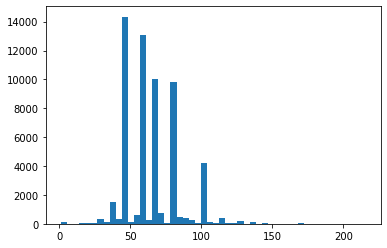

In [102]:
plt.hist(pow(data1["Loan_Amount_Applied"],1/2), bins=50)
plt.show()

plt.hist(pow(data1["Loan_Amount_Applied"],1/3), bins=50)
plt.show()

In [103]:
#Nadpisanie wartości zmiennej
data["Loan_Amount_Applied"] = pow(data["Loan_Amount_Applied"], 1/3)

Zmienna Loan_Tenure_Applied podobnie jak Loan_Amount_Applied ma 71 braków oraz minimalną wartość równą 0, świadczącą o błędzie w danych. Podejście będzie analogiczne jak poprzednio.

In [104]:
#Sprawdzenie wartości 0
query_lt0 = data["Loan_Tenure_Applied"] == 0
zeros=data.loc[query_lt0]
zeros["Gender"].count() 

33844

In [105]:
#Wyliczenie poprawnej mediany (na wartościach bez bez nulli i zer)
data2=data.query('Loan_Tenure_Applied > 0')

med_ten_appl=data2["Loan_Tenure_Applied"].median()
med_ten_appl

3.0

In [106]:
#Wypełnienie braków
data["Loan_Tenure_Applied"]=data["Loan_Tenure_Applied"].replace(np.nan, med_ten_appl)

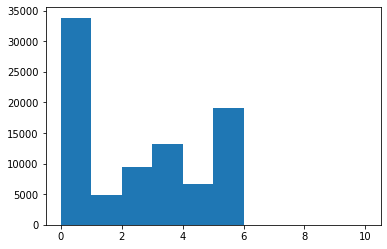

In [107]:
plt.hist(data["Loan_Tenure_Applied"])
plt.show()

Nazwa zmiennej Existing_EMI (equated monthly installment) sugeruje, że będzie miała ona wartość powyżej 0, kiedy klient ma inne zobowiązania, które spłaca. Wartośc 0 wydaje się być poprawną wartością. Nulle (71 przypadków) zostaną nadpisane wartością mediany dla obserwacji, gdzie EMI>0. Rozkład zmiennej zostanie zbadany. Wartości znacząco powyżej średniej mogą być wartościami błędnymi. 

In [108]:
#Sprawdzenie liczby przypadków wartości 0
query_emi = data["Existing_EMI"] == 0
zeroemi=data.loc[query_emi]
zeroemi["Gender"].count() 

58238

In [109]:
#Wyliczenie mediany (na wartościach bez bez nulli i zer)
data3=data.query('Existing_EMI > 0')

med_emi=data3["Existing_EMI"].median()
med_emi

6000.0

In [110]:
#Wypełnienie braków
data["Existing_EMI"]=data["Existing_EMI"].replace(np.nan, med_emi)
#data["Existing_EMI"].isnull().sum()

In [111]:
#Sprawdzenie wartości odstających
print(f'99 percentyl: {np.percentile(data3["Existing_EMI"], 99)}')
print(f'99.9 percentyl: {np.percentile(data3["Existing_EMI"], 99.9)}')
print(f'99.99 percentyl: {np.percentile(data3["Existing_EMI"], 99.99)}')
print(f'max: {max(data["Existing_EMI"])}')

99 percentyl: 65000.0
99.9 percentyl: 150000.0
99.99 percentyl: 446608.3139994177
max: 10000000.0


In [112]:
cap_emi= np.percentile(data3["Existing_EMI"], 99)
query_outemi = data["Existing_EMI"] > cap_emi
outemi=data.loc[query_outemi]
outemi["Gender"].count() 

273

Jest tylko 18 przypadków, gdzie zmienna Existing_EMI przekracza 99.9 percentyl. Przypadków, gdzie zmienna przekracza 99 percentyl jest tylko 273. Wartości odstające zostaną przycięte do 99 percentyla.

In [113]:
#Nadpisanie wartości
data.loc[query_outemi, "Existing_EMI"] = cap_emi

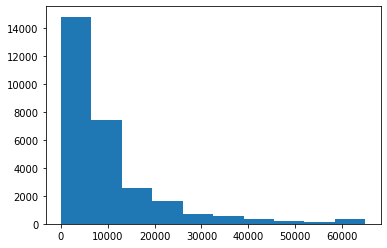

In [114]:
emi_hist=data.query('Existing_EMI > 0')
plt.hist(emi_hist["Existing_EMI"])
plt.show()

Rozkład zmiennej jest skośny i zostanie poprawiony - na wartość zmiennej zostanie nałożony pierwiastek.

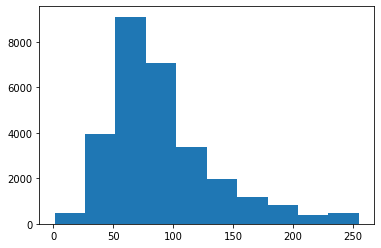

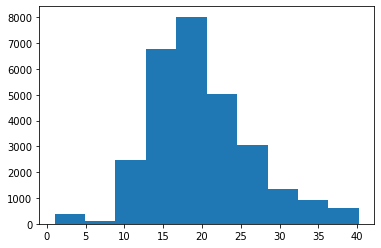

In [115]:
plt.hist(pow(emi_hist["Existing_EMI"], 1/2))
plt.show()
         
plt.hist(pow(emi_hist["Existing_EMI"], 1/3))
plt.show()

In [116]:
#Nadpisanie wartości zmiennej pierwiastkiem sześciennym
data["Existing_EMI"] = pow(data["Existing_EMI"], 1/3)

Zmienna Var5 jest zmienną ciągłą poklasyfikowaną. Nie ma braków - nie wymaga dalszych poprawek

Zmienne Loan_Amount_Submitted oraz Loan_Tenure_Sumbitted posiadają bardzo dużo braków (ok 1/3 przypadków). Zmienne te nie mają wartości 0. Najpierw zostanie sprawdzone, czy wśród przypadków z missingiem znajdują sie takie, dla których Disbursed = 1. Jeśli tak, to zmienna będzie mieć przypisany specjalny poziom dla braków - zostanią nadpisane wartościami zmiennych _Applied.

In [117]:
nulls_las=data[data["Loan_Amount_Submitted"].isnull()==1]

print(nulls_las["Disbursed"].sum())
print(nulls_las["Disbursed"].count())

#Są przypadki z "Disbursed"=1.

229
34613


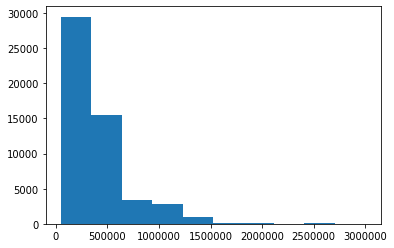

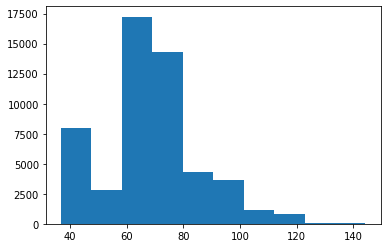

In [118]:
#Przed nadpisaniem należy sprawdzić rozkłady zmiennych i dokonać analogicznego przekształcenia jak na zmiennych _Applied.
las=data[data["Loan_Amount_Submitted"]>1]

plt.hist(las["Loan_Amount_Submitted"])
plt.show()

plt.hist(pow(las["Loan_Amount_Submitted"], 1/3))
plt.show()

In [119]:
#Nadpisanie wartości pierwiastkami sześciennymi wartości
data["Loan_Amount_Submitted"] = pow(data["Loan_Amount_Submitted"], 1/3)

In [120]:
#Nadpisanie nulli wartościami zmiennej Loan_Amont_Applied
data["Loan_Amount_Submitted"]=np.where(data["Loan_Amount_Submitted"].isnull()==True, data["Loan_Amount_Applied"], data["Loan_Amount_Submitted"])

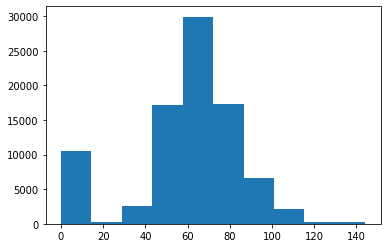

In [121]:
plt.hist(data["Loan_Amount_Submitted"])
plt.show()

In [122]:
#Check
#c=data[data["Loan_Amount_Submitted"]!=data["Loan_Amount_Applied"]]
#c["Gender"].count()

In [123]:
#Zmienna Loan_Tenure_Submitted w miejscach, gdzie jest pusta przyjmie wartość zmiennej Loan_Tenure_Applied
data["Loan_Tenure_Submitted"]=np.where(data["Loan_Tenure_Submitted"].isnull()==True, data["Loan_Tenure_Applied"], data["Loan_Tenure_Submitted"])

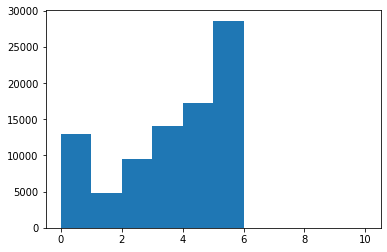

In [124]:
plt.hist(data["Loan_Tenure_Submitted"])
plt.show()

Zmienne EMI_Loan_Submitted, Processing_Fee oraz Interest_Rate zawierają bardzo dużo nulli (ponad 59tys). Najpierw zostanie sprawdzone, czy wśród przypadków z wartością null występują przypadki, gdzie Disbursed=1, a następnie (jeśli tak) puste miejsca zostaną wypełnione. Rozkład zmiennej EMI_Loan_Submitted jest skośny - zostanie ona przekształcona (pierwiastek).

In [125]:
for variable in ["EMI_Loan_Submitted", "Processing_Fee", "Interest_Rate"]:
    nulls=data[data[variable].isnull()==1]
    print(nulls["Disbursed"].sum())

682
689
682


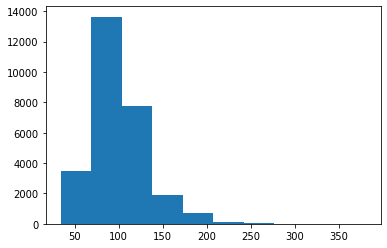

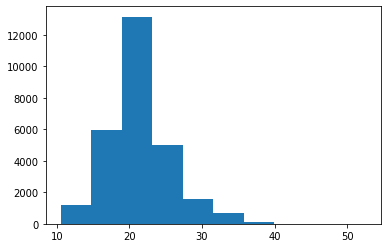

In [126]:
plt.hist(pow(data["EMI_Loan_Submitted"],1/2))
plt.show()

plt.hist(pow(data["EMI_Loan_Submitted"],1/3))
plt.show()

In [127]:
data["EMI_Loan_Submitted"] = pow(data["EMI_Loan_Submitted"], 1/3)

In [128]:
#Zmienna EMI_Loan_Submitted nie posiada wartości 0 - braki zostaną nadpisane 0.
data["EMI_Loan_Submitted"] = data["EMI_Loan_Submitted"].replace(np.nan, 0)

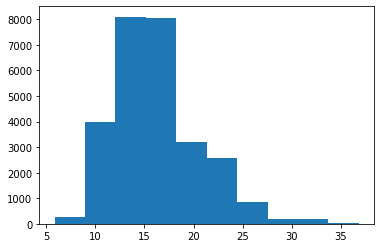

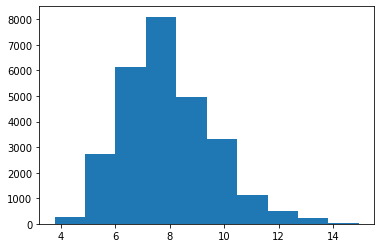

In [129]:
#Processing_Fee także ma skośny rozkład - procedura będzie taka sama, jak dla poprzedniej zmiennej.
plt.hist(pow(data["Processing_Fee"],1/3))
plt.show()

plt.hist(pow(data["Processing_Fee"],1/4))
plt.show()

In [130]:
data["Processing_Fee"] = pow(data["Processing_Fee"], 1/4)

In [131]:
#Zmienna Processing_Fee nie posiada wartości 0 - braki zostaną nadpisane 0.
data["Processing_Fee"] = data["Processing_Fee"].replace(np.nan, 0)

In [132]:
#Interest_Rate jest zmienną bimodalną - jej wartości zostaną niezmienione, a wartości null zostana zaimputowane 0.
data["Interest_Rate"] = data["Interest_Rate"].replace(np.nan, 0)

In [135]:
#Sprawdzenie danych
#data.isnull().sum()

#### Przygotowanie do modelowania

In [136]:
#Stworzenie dummies na zmiennych jakościowych
#Z kazdej z dummies zostanie usunięty 1 poziom, aby nie powielac informacji (liniowa niezalezność)
data_fin=pd.get_dummies(data, columns=dummy, drop_first=True)

In [137]:
data_fin.head()

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Disbursed,...,Var4_2,Var4_3,Var4_4,Var4_5,Var4_6,Var5_123,Var5_45678,Var5_131415,Var5_161718,Var5_9101112
0,27.144176,66.943295,5.0,0.000000,66.943295,5.0,0.00,0.0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,32.710663,58.480355,2.0,0.000000,58.480355,2.0,13.25,0.0,18.910847,0,...,0,1,0,0,0,0,0,1,0,0
2,28.231081,84.343267,4.0,0.000000,76.630943,4.0,0.00,0.0,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
3,32.710663,100.000000,5.0,0.000000,97.258883,5.0,0.00,0.0,0.000000,0,...,0,1,0,0,0,0,0,0,0,1
4,46.415888,79.370053,2.0,29.240177,79.370053,2.0,0.00,0.0,0.000000,0,...,0,1,0,0,0,0,0,0,1,0


In [138]:
#Podział zbioru na testowy i uczący
X=data_fin.drop(columns=["Disbursed"])
y=data_fin["Disbursed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [139]:
print(y_test.count())
print(y_test.sum())

17404
268


In [140]:
print(y_train.count())
print(y_train.sum())

69616
1005


In [182]:
#Zdefiniowanie parametru do kroswalidacji
kfold = StratifiedKFold(n_splits=5, shuffle=False)
#kfold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [141]:
#Ewentualny undersampling

In [151]:
##Podział wartości na 0 i 1.
#X_values = X_train.values
#y_values = y_train.values
#X_0 = X_values[y_values == 0, :]
#X_1 = X_values[y_values == 1, :]
#
#print(X_0.shape, X_1.shape)

(68611, 71) (1005, 71)


In [152]:
##Losowy wybór indeksów z klasy o większej liczności.
#param=4
#indices_0_under = np.random.choice(X_0.shape[0], size=X_1.shape[0]*param, replace=False)
#
#X_under_0 = X_0[indices_0_under]
#X_under = np.vstack([X_under_0, X_1])
#y_under = np.array([0]*X_under_0.shape[0] + [1]*X_1.shape[0])
#
#print(X_under.shape, y_under.shape)

(5025, 71) (5025,)


#### Budowa modeli - drzewo decyzyjne

In [196]:
pipe1 = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', DecisionTreeClassifier(class_weight={0:1, 1:9}, random_state=123))
])

param_grid1 = {
            'scaler': [StandardScaler(), None],
            'classifier__max_depth': [5,6,7,8,9,10],
            'classifier__min_samples_leaf': [10, 15, 20, 25, 30],
            'classifier__max_leaf_nodes': [2, 3, 4]
}

grid1 = GridSearchCV(pipe1, param_grid1, cv=kfold, return_train_score=True,  n_jobs=-1)

grid1.fit(X_train, y_train)
#grid1.fit(X_under, y_under)
grid1.best_params_

{'classifier__max_depth': 5,
 'classifier__max_leaf_nodes': 2,
 'classifier__min_samples_leaf': 10,
 'scaler': StandardScaler()}

#### Budowa modeli - XGB

In [184]:
pipe2 = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', xgboost.XGBClassifier(n_estimators=700, random_state=123))
])

param_grid2 = {
            'scaler': [StandardScaler(), None],
            'classifier__max_depth': [4, 6, 8, 9],
            'classifier__learning_rate': [0.005, 0.01, 0.05]
}

grid2 = GridSearchCV(pipe2, param_grid2, cv=kfold, return_train_score=True, n_jobs=-1)

#grid2.fit(X_train, y_train)
grid2.fit(X_under, y_under)
grid2.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__max_depth': 9,
 'scaler': StandardScaler()}

#### Budowa modeli - regresja logistyczna

In [185]:
pipe3 = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', LogisticRegression(class_weight={0:1, 1:9}, max_iter=1000000, solver='newton-cg', random_state=123))
])

param_grid3 = {
            'classifier__C': [0.0001, 0.0005, 0.001, 0.005, 0.05, 0.01]
}

grid3 = GridSearchCV(pipe3, param_grid3, cv=kfold,  n_jobs=-1)

grid3.fit(X_train, y_train)
grid3.best_params_

{'classifier__C': 0.0001}

#### Budowa modeli - Random Forest

In [186]:
pipe4 = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', RandomForestClassifier(class_weight={0:1, 1:20}, n_estimators=700, random_state=123))
])

param_grid4 = {
            'scaler': [StandardScaler(), None],
            'classifier__max_depth': [4, 6, 8, 10],
            'classifier__min_samples_leaf': [10, 12, 13, 15]
}

grid4 = GridSearchCV(pipe4, param_grid4, cv=kfold, return_train_score=True,  n_jobs=-1)

grid4.fit(X_train, y_train)
grid4.best_params_

{'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 12,
 'scaler': StandardScaler()}

#### Budowa modeli - Bagging

In [193]:
pipe5 = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', BaggingClassifier(DecisionTreeClassifier(class_weight={0:1, 1:9}), n_estimators=700, bootstrap=True, random_state=123))
])

param_grid5 = {
            'scaler': [StandardScaler(), None],
            'classifier__max_samples': [5, 7, 10, 12],
            'classifier__max_features': [5, 7, 10,15],
}

grid5 = GridSearchCV(pipe5, param_grid5, cv=kfold, return_train_score=True,  n_jobs=-1)

grid5.fit(X_train, y_train)
grid5.best_params_

{'classifier__max_features': 5,
 'classifier__max_samples': 5,
 'scaler': StandardScaler()}

#### Budowa modeli - GradientBoosting

In [190]:
pipe6 = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', GradientBoostingClassifier(n_estimators=400, random_state=123))
])

param_grid6 = {
            'scaler': [StandardScaler(), None],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [6,8],
}

grid6 = GridSearchCV(pipe6, param_grid6, cv=kfold, return_train_score=True,  n_jobs=-1)

grid6.fit(X_train, y_train)
grid6.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__max_depth': 6,
 'scaler': StandardScaler()}

#### Sprawdzenie jakości modeli + porównanie metod

In [197]:
models = []
models.append(('Decision Tree', grid1.best_estimator_))
models.append(('XGB', grid2.best_estimator_))
models.append(('Logistic Regression', grid3.best_estimator_))
models.append(('Random Forest', grid4.best_estimator_))
models.append(('Bagging', grid5.best_estimator_))
models.append(('GradientBoosting', grid6.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

Decision Tree
precision_score: 0.16452991452991453
recall_score: 0.2873134328358209
f1_score: 0.20923913043478262
accuracy_score: 0.9665594116295104
XGB
precision_score: 0.13544018058690746
recall_score: 0.6716417910447762
f1_score: 0.22542266750156548
accuracy_score: 0.9289243851988048
Logistic Regression
precision_score: 0.2682926829268293
recall_score: 0.20522388059701493
f1_score: 0.23255813953488375
accuracy_score: 0.9791427258101586
Random Forest
precision_score: 0.2535211267605634
recall_score: 0.20149253731343283
f1_score: 0.22453222453222452
accuracy_score: 0.9785681452539646
Bagging


C:\Users\bl06gb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_score: 0.0
recall_score: 0.0
f1_score: 0.0
accuracy_score: 0.9846012410940014


C:\Users\bl06gb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoosting
precision_score: 0.5294117647058824
recall_score: 0.033582089552238806
f1_score: 0.0631578947368421
accuracy_score: 0.9846586991496208


In [198]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['Decision Tree', 'XGB', 'Logistic Regression', 'Random Forest', 'Bagging', 'GradientBoosting'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,Decision Tree,0.164530,0.287313,0.209239,0.966559
1,XGB,0.135440,0.671642,0.225423,0.928924
2,Logistic Regression,0.268293,0.205224,0.232558,0.979143
3,Random Forest,0.253521,0.201493,0.224532,0.978568
4,Bagging,0.000000,0.000000,0.000000,0.984601
5,GradientBoosting,0.529412,0.033582,0.063158,0.984659
